# 📚  Exercise Session - Week 6, Part 2
**Main Topics**: Generation, Decoding, Beam-search, Sampling, NLG Eval Metrics


Welcome to Week 6 of CS-552 Modern NLP's exercise sessions!
The aim of this exercise is to get yourself acquainted with generation algorithms that are used with language models. In this notebook, you will learn how to implement different text generation algorithms.


- [🔧 Setup](#Setup)
- [🧠 1) Text Generation Algorithms](#1\)-Text-Generation-Algorithms)
  - [👉 1.1 Greedy Decoding](#1.1-Greedy-Decoding)
  - [👉 1.2 Beam Search](#1.2-Beam-Search)
  - [👉 1.3 Top-k Sampling](#1.3-Top-k-Sampling)
  - [👉 1.4 Top-p Sampling](#1.4-Top-p-Sampling)
- [🧪 2) MT Evaluation](#2\)-MT-Evaluation)
  - [📊 2.1 Dataset and metrics analysis](#2.1-Dataset-and-metrics-analysis)
  - [🧮 2.2 NLG metric calculation](#2.2-NLG-metric-calculation)
  - [📈 2.3 Correlation calculation](#2.3-Correlation-calculation)
  - [🔍 2.4 Correlation analysis](#2.4-Correlation-analysis)


## Setup

First, if you are using Google Colab, go through part (1) and (3) of the setup section. If not, and you are using a local machine, go through the part (2) and (3) of the setup section.

### 1) Google Colab Setup

If you are using Google Colab for this assignment, you will need to run a few commands to set up our environment. If you are running this notebook on a local machine you can skip this section.
- First, upload the `Part 2` folder on your Google Drive.
- Run the following cell to mount your Google Drive. Follow the popped window, sign in to your Google account (i.e., the same non-EPFL account under which you uploaded the folder)

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

Now, 
- first click the 4th left-side button (named Files), then click the 2nd button that pops under in the columns (named Refresh), 
- under "/drive/MyDrive/" find the `Part 2` folder that you uploaded to your Google Drive, 
- copy its path, and fill it in the cell below. 

If everything is working correctly, then running the following cell should print the filenames from the folder:

```
['data', 'Week_6_Part_2_Solutions.ipynb', 'decoding.py', 'mt_eval.py', 'part2_corr.json', 'part2_metrics.json', 'requirements.txt', 'sampling.py', 'tests.py', 'utils.py']
```

In [ ]:
# import os
# # TODO: Fill in the `ROOT_PATH` with where you uploaded the Part 2 folder
# ROOT_PATH = "/content/drive/MyDrive/..."  # Replace with your directory to Part 2 folder
# print(os.listdir(ROOT_PATH)) # Check the content of the path
# os.chdir(ROOT_PATH) # cd into directory
# print(os.listdir(".")) # Check the content of current folder

And the following cell should read "Hello, this is Part 2 of Week 6 exercise! You successfully linked your directory to Colab."


In [ ]:
# from tests import hello_W6P2
# hello_W6P2()

Before we start, we also need to run some boilerplate code to set up our environment, same as previous assignments.

In [ ]:
# requirements = ROOT_PATH + "/requirements.txt"
# %pip install -r {requirements}

### 2) Local Setup

If you are using a local setup, then make sure you have a python environment create for Python 3.10 (you can use the same one from Week 1). For example you can use the following command to create a conda environment if you haven't done so for previous exercises or assignments:

```shell
conda create -n="mnlp-venv" python=3.10.12
conda activate mnlp-venv
```

And download the requirements:
```
pip install -r requirements.txt
```

And then make sure to set the kernel of this notebook to that environment, such as when using VS Code.

Below please write your filepath to your `Part 2` folder. If everything is working correctly, then running the following cell should print the filenames from the folder:

```
['data', 'Week_6_Part_2_Solutions.ipynb', 'decoding.py', 'mt_eval.py', 'part2_corr.json', 'part2_metrics.json', 'requirements.txt', 'sampling.py', 'tests.py', 'utils.py']
```

In [1]:
import os

ROOT_PATH = "." # Replace with your directory to Part 2 folder
print(os.listdir(ROOT_PATH))

['Week_6_Part_2_Solutions.ipynb', 'data', 'decoding.py', 'mt_eval.py', 'part2_corr.json', 'part2_metrics.json', 'requirements.txt', 'sampling.py', 'tests.py', 'utils.py']


### 3) Rest of the setup (Colab and Local)

Now, run this cell to load the autoreload extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience without needing to restart the kernel.

In [ ]:
%load_ext autoreload
%autoreload 2

from utils import *
from tests import *

import json
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM
)

seed = 84
torch.manual_seed(seed) # example to set the seed for randomness control
torch.set_printoptions(precision=16) # set print number precision at 16

If you would like to setup CUDA with your notebook you can check whether it's available or not. If not, either your local machine doesn't have GPUs or you need to change your runtime type to a GPU setting via `Edit -> Notebook Settings` on Colab.

In [3]:
if torch.cuda.is_available():
    print("GPU is available! Good to go.")
else:
    print(
        "If you are using Colab, please set your runtime type to a GPU via {Edit -> Notebook Settings}."
    )

GPU is available! Good to go.


And that's it! You are ready to start the exercise.

## 1) Text Generation Algorithms

- In this section you are going to implement decoding and sampling algorithms in files `decoding.py` and `sampling.py`. 
- Keep testing your code in between different algorithms. 
- You can modify the main function in these files to test your functions. 
- We have also created the "test" cells to call your functions and see if they implement the features we request. 
- We don't expect you to throw errors when the inputs don't match their constraints, but whenever the constraints are not met, we return None and print statements to help you debug.

### 1.1 Greedy Decoding

🎯 Implement the `search` function in `GreedySearchDecoderForCausalLM` class in `decoding.py`

#### Using KV cache

Instead of recomputing the decoder hidden states as done above, we can also use cached decoder hidden states at each decoding step:

To speed up the process you can get the computed keys / values hidden-states *so far* with `use_cache=True` where you do:
```python
>> self.model(**inputs, use_cache=True)
```

This will return an extra dictionary entry called "past_key_values". Assuming your previous output dict is called `outputs`, in subsequent calls, you pass this dictionary back to the model as follows:
```python
>> self.model(**inputs, use_cache=True, past_key_values=outputs["past_key_values"])
```

Read the `Parameters` and `Returns` sections of the [GPT2LMHeadModel](https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2LMHeadModel) carefully to note how the two settings of using cache and not using cache differ, in particular how to modify the "input_ids" and "attention_mask" across decoding steps for the two cases.

Checkout the version of greedy decoding in `decoding.py` that uses cache.

#### Testing your implementation

Let's first load up the relevant language modeling class, its tokenizer, and the datapoints you can test your algortihm on. Then we will create instances of our decoding and sampling classes. 

You will test your implementation on [an instruction-tuned GPT-2 small from Huggingface Model Hub](https://huggingface.co/vicgalle/gpt2-alpaca-gpt4) called `vicgalle/gpt2-alpaca-gpt4`. This model was finetuned on a dataset in the format of instructions followed by demonstrations. 
The instruction datapoints come from the [Alpaca](https://crfm.stanford.edu/2023/03/13/alpaca.html) dataset, which, if you are curious about, you can load with:

```python
>> from datasets import load_dataset
>> dataset = load_dataset("tatsu-lab/alpaca")
```

> References: Here is the [Alpaca](https://crfm.stanford.edu/2023/03/13/alpaca.html) and [Self-Instruct](https://arxiv.org/abs/2212.10560) paper if you are interested in the topic of instruction tuning!

In [4]:
################################################################################
# 1) Load model and tokenizer
# model_name = "gpt2" # NOTE: the quality of the generations will be low if you use gpt2
model_name = "vicgalle/gpt2-alpaca-gpt4"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id
model = AutoModelForCausalLM.from_pretrained(model_name)
MAX_SEQ_LENGTH = tokenizer.model_max_length

################################################################################
# 2) Load relevant data
with open(os.path.join(ROOT_PATH, "data", "part1_input_data.json"), "r") as read_file:
    input_data = json.load(read_file)

# 3) Format the data in the instruction template: in particular,
#    we follow the template the model was finetuned on
all_inputs = []
for i, entry in enumerate(input_data):
    print("-" * 50)
    print(f"Entry #{i + 1}:")
    print("-" * 40)
    final_text = ""
    if entry["input"] == "":
        final_text = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
        final_text += "\n\n### Instruction:\n" + entry["instruction"]
    else:
        final_text = "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request."
        final_text += "\n\n### Instruction:\n" + entry["instruction"]
        final_text += "\n\n### Input:\n" + entry["input"]
    final_text += "\n\n### Response:\n"

    print(final_text)

    ############################################################################
    # 4) Tokenize the relevant text
    curr_inputs = tokenizer(
        final_text,
        max_length=MAX_SEQ_LENGTH,
        truncation=True,
        return_tensors="pt",
    )

    all_inputs.append([f"Entry #{i + 1}", curr_inputs])

--------------------------------------------------
Entry #1:
----------------------------------------
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Given an economic concept, define it in simple terms.

### Input:
Inflation

### Response:

--------------------------------------------------
Entry #2:
----------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Generate a poem about spring.

### Response:

--------------------------------------------------
Entry #3:
----------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Generate a list of ten items a person might need for a camping trip

### Response:



In [5]:
################################################################################
# 4) Put model & inputs on CUDA if available
print("-" * 50)
print("CUDA:")
print("-" * 40)


def get_device():
    device = None
    # NOTE: Feel free to uncomment the "mps" lines if you want to use the ARM GPU.
    # if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    #     device = torch.device("mps")
    #     return device
    if torch.cuda.is_available():
        # TODO: if you want a specific GPU, you can choose which device here,
        #       otherwise picks the default 0 ID-ed GPU
        device = torch.device("cuda:0")
        print("CUDA was available, successfully put inputs and model on GPU device.")
    else:
        device = torch.device("cpu")
        print("Not putting inputs and model on any GPU device.")
    return device


device = get_device()
model = model.to(device)
for _, inputs in all_inputs:
    inputs["input_ids"] = inputs["input_ids"].to(device)
    inputs["attention_mask"] = inputs["attention_mask"].to(device)

--------------------------------------------------
CUDA:
----------------------------------------
CUDA was available, successfully put inputs and model on GPU device.


Perfect! Now you can use the following tests to debug the behavior of your model. Feel free to play around with the parameters but do not change the `tests.py` file.

#### Greedy search test

Greedy search is the first thing you can implement. The output here should match the huggingface implementation. Make sure you implement the *max_new_tokens* parameter behavior right!
- 🎯 You need to implement the `search` function in `GreedySearchDecoderForCausalLM` class in `decoding.py` to run this test


In [6]:
from importlib import reload
import tests
reload(tests)
from tests import greedy_test

# 1) Relevant parameters to greedy search
max_new_tokens = 20

# 2) Run it on the 3 examples
greedy_test(
    model,
    tokenizer,
    all_inputs,
    max_new_tokens,
    verbose=True,  # NOTE: set it to True/False to show/hide the decoded sequence, can help debugging
    with_color=True,  # NOTE: set it to True/False to choose whether to display
    #                         the input sequence (red) and the generated sequence (green) in diff colors
)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Greedy Tests
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
--------------------------------------------------
Input:  Entry #1
--------------------------------------------------
~ Your Implementation ~
cuda:0
Generated sequence: 
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Given an economic concept, define it in simple terms.

### Input:
Inflation

### Response:
Inflation is the rate at which the value of a currency fluctuates over time. It is the
Output shape:  torch.Size([1, 71])
--------------------
~ Huggingface Implementation ~
Generated sequence: 
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Given an economi

### 1.2 Beam Search

#### 1.2.a) Beam search test without length penalty

Next, we implement beam search. First, implement it without length penalty and see if the log probability scores you get are roughly close to huggingface's for different beam sizes (particularly smaller ones). The sequence should be mostly the same, independent of the beam width.
- 🎯 You need to implement the `search` function in `BeamSearchDecoderForCausalLM` class in `decoding.py` to run this test (you don't have to implement the *length_penalty* feature to run it)

In [7]:
from importlib import reload
import tests
reload(tests)
from tests import beam_test

# 1) Relevant parameters to beam search
max_new_tokens = 15
num_beams = 4
num_return_sequences = 4
length_penalty = 0.0

# 2) Run it on the 3 examples
beam_test(
    model,
    tokenizer,
    all_inputs,
    max_new_tokens,
    num_beams,
    length_penalty,
    num_return_sequences,
    verbose=True,  # NOTE: set it to True/False to show/hide the decoded sequence, can help debugging
    with_color=True,  # NOTE: set it to True/False to choose whether to display
    #                         the input sequence (red) and the generated sequence (green) in diff colors
)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Beam Tests
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
--------------------------------------------------
Input:  Entry #1
--------------------------------------------------
~ Your Implementation ~


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


1. score: -9.55841850899742
1. Generated sequence:
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Given an economic concept, define it in simple terms.

### Input:
Inflation

### Response:
Inflation is the rate at which the purchasing power of a currency fluctuates
2. score: -9.595272032311186
2. Generated sequence:
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Given an economic concept, define it in simple terms.

### Input:
Inflation

### Response:
Inflation is the increase in the price of goods and services over time,
3. score: -9.803230253746733
3. Generated sequence:
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

###

#### 1.2.b) Beam search test with length penalty

Next, we implement length penalty for beam search. We do so by dividing the score (sum of the log probabilities) by the length of the generation exponentiated by the penalty. 
- 🎯 You need to implement the `search` function in `BeamSearchDecoderForCausalLM` class in `decoding.py` with *length_penalty* to run this test. Make sure your changes do not change the outcome of the without-length-penalty version.

In [8]:
from importlib import reload
import tests
reload(tests)
from tests import beam_test

# 1) Relevant parameters to beam search + penalty
max_new_tokens = 15
num_beams = 5
num_return_sequences = 3
length_penalty = 1.5

# 2) Run it on the 3 examples
beam_test(
    model,
    tokenizer,
    all_inputs,
    max_new_tokens,
    num_beams,
    length_penalty,
    num_return_sequences,
    verbose=False,  # NOTE: set it to True/False to show/hide the decoded sequence, can help debugging
    with_color=True,  # NOTE: set it to True/False to choose whether to display
    #                         the input sequence (red) and the generated sequence (green) in diff colors
)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Beam Tests
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
--------------------------------------------------
Input:  Entry #1
--------------------------------------------------
~ Your Implementation ~


1. score: -0.16453153645078994
2. score: -0.16516590570431564
3. score: -0.16874554449687915
Output shape:  torch.Size([3, 66])
--------------------
~ Huggingface Implementation ~
1. score: -0.16453354060649872
2. score: -0.16516633331775665
3. score: -0.16874630749225616
Output shape:  torch.Size([3, 66])
--------------------
~ Summary ~
Output IDs matching:  ['✅', '✅', '✅']
Output shape matching:  ✅
Scores approximately close (to 0.1 decimal):  ['✅', '✅', '✅']


--------------------------------------------------
Input:  Entry #2
--------------------------------------------------
~ Your Implementation ~
1. score: -0.2902206114797574
2. score: -0.30793950826745564
3. score: -0.3111090518488532
Output shape:  torch.Size([3, 45])
--------------------
~ Huggingface Implementation ~
1. score: -0.2902231514453888
2. score: -0.30794093012809753
3. score: -0.31110650300979614
Output shape:  torch.Size([3, 45])
--------------------
~ Summary ~
Output IDs matching:  ['✅', '✅', '✅']
Output shape

In [11]:
from importlib import reload
import tests
reload(tests)
from tests import beam_test

# 1) Relevant parameters to beam search + penalty
max_new_tokens = 25
num_beams = 5
num_return_sequences = 3
length_penalty = -1.5

# 2) Run it on the 3 examples
beam_test(
    model,
    tokenizer,
    all_inputs,
    max_new_tokens,
    num_beams,
    length_penalty,
    num_return_sequences,
    verbose=False,  # NOTE: set it to True/False to show/hide the decoded sequence, can help debugging
    with_color=True,  # NOTE: set it to True/False to choose whether to display
    #                         the input sequence (red) and the generated sequence (green) in diff colors
)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Beam Tests
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
--------------------------------------------------
Input:  Entry #1
--------------------------------------------------
~ Your Implementation ~
1. score: -2172.3956499190535
2. score: -2228.705904999515
3. score: -2356.491712940624
Output shape:  torch.Size([3, 76])
--------------------
~ Huggingface Implementation ~
1. score: -2172.400390625
2. score: -2228.706787109375
3. score: -2356.496826171875
Output shape:  torch.Size([3, 76])
--------------------
~ Summary ~
Output IDs matching:  ['✅', '✅', '✅']
Output shape matching:  ✅
Scores approximately close (to 0.1 decimal):  ['✅', '✅', '✅']


--------------------------------------------------
Input:  Entry #2
--------------------------------------------------
~ Your Implementation ~
1. score: -3063.1921044550836
2. score: -3107.638424495235
3. score: -3127.82857334241

### 1.3 Top-k Sampling

Next, we implement top-k sampling.
- 🎯 You need to implement the `sample` function in `TopKSamplerForCausalLM` class in `sampling.py` to run this test.

In [9]:
from importlib import reload
import tests
reload(tests)
from tests import top_k_test

# 1) Relevant parameters to sampling
max_new_tokens = 20
top_k = 15
temperature = 0.7
seed = 84

# 2) Run it on the 3 examples
top_k_test(
    model,
    tokenizer,
    all_inputs,
    max_new_tokens,
    top_k,
    temperature,
    seed,
    verbose=True, # NOTE: set it to True/False to show/hide the decoded sequence, can help debugging
    with_color=True, # NOTE: set it to True/False to choose whether to display
    #                         the input sequence (red) and the generated sequence (green) in diff colors
)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Top-k Tests
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
--------------------------------------------------
Input:  Entry #1
--------------------------------------------------
~ Your Implementation ~
Generated sequence: 
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Given an economic concept, define it in simple terms.

### Input:
Inflation

### Response:
Inflation is the price of money, the sum of money's value, or interest paid on money
Output shape:  torch.Size([1, 71])
--------------------
~ Huggingface Implementation ~
Generated sequence: 
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Given an economic concept,

/datadrive/madhur/anaconda3/envs/mnlp_exercises/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:677: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Generated sequence: 
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Generate a poem about spring.

### Response:
Spring is the moment when we all start to melt
A new season to bloom 
A new
Output shape:  torch.Size([1, 50])
--------------------
~ Huggingface Implementation ~
Generated sequence: 
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Generate a poem about spring.

### Response:
Spring's sweet fragrance
In the air,
A gentle breeze, a gentle breeze

The
Output shape:  torch.Size([1, 50])
--------------------------------------------------
Input:  Entry #3
--------------------------------------------------
~ Your Implementation ~
Generated sequence: 
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Generate a list of ten items a person might need for a camp

### 1.4 Top-p Sampling

Now, we implement top-p sampling.
- 🎯 You need to implement the `sample` function in `TopPSamplerForCausalLM` class in `sampling.py` to run this test.


In [10]:
from importlib import reload
import tests
reload(tests)
from tests import top_p_test

# 1) Relevant parameters to top-p
max_new_tokens = 20
top_p = 0.92
temperature = 0.7
seed = 84

# 2) Run it on the 3 examples
top_p_test(
    model,
    tokenizer,
    all_inputs,
    max_new_tokens,
    top_p,
    temperature,
    seed,
    verbose=True,  # NOTE: set it to True/False to show/hide the decoded sequence, can help debugging
    with_color=True,  # NOTE: set it to True/False to choose whether to display
    #                         the input sequence (red) and the generated sequence (green) in diff colors
)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Top-p Tests
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
--------------------------------------------------
Input:  Entry #1
--------------------------------------------------
~ Your Implementation ~
Generated sequence: 
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Given an economic concept, define it in simple terms.

### Input:
Inflation

### Response:
Inflation is the effect of a person's purchasing power falling below the level of inflation, usually as
Output shape:  torch.Size([1, 71])
--------------------
~ Huggingface Implementation ~
Generated sequence: 
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Given a

## 2) MT Evaluation

In this section, you will be evaluating several NLG metrics to understand which ones correlate best with human judgement when it comes to machine translation (MT), a popular task in NLG. 
- You are not required to implement anything in this section. 
- The code in this section is not a part of exam material for the midterm.
- You are not required to run the cells in this section; the outputs are precomputed and you can observe them as is.
- Your task is to have a look at the code, understand it at a high-level, analyze the outputs, and then answer comprehension questions to aid your understanding.
- We will first take a close look at one of the [Workshop on Statistical Machine Translation](https://aclanthology.org/venues/wmt/) (WMT) datasets. 
- WMT provides several challenges each year it's hosted to evaluate MT systems (e.g., you can consider Google Translate as a system), and also to evaluate the metrics we use. You read that right: we will evaluate evaluation! 
- While there are several WMT datasets that you can find [here](https://github.com/Unbabel/COMET/blob/master/data/README.md), we will focus on a Direct Assessment (DA) dataset.

### 2.1 Dataset and metrics analysis

The DA scores are human evaluation scores such that given a **source** (`src`) sentence from one source language and a target **reference** (`ref`) from a distinct target language, the annotator evaluates how good the **hypothesis** (`mt`), or, in other words, the prediction of the machine translation system is. Such scores are typically calculated by several metrics and then aggregated with weighing (also called Multidimensional Quality Metrics - MQM) or they can be raw scores on a given scale which are then normalized across annotators. The DA score in the dataset we will evaluate was collected in the latter way.

We subsampled a huggingface dataset instance of the WMT Shared Tasks which can be found [here](https://huggingface.co/datasets/RicardoRei/wmt-da-human-evaluation). In particular, we subsampled in each source sentence (`src`) and language pair (`lp`) group from 2019 such that we could get roughly equal amounts of data in each category. Let's do a quick analysis to get you accustomed to the data format:

In [1]:
import os
import pandas as pd


def cnt_unique_prop(dataset, prop_name, do_print=True):
    uniques = dataset[prop_name].unique().tolist()
    print("(" + prop_name + ") # of unique instances: ", len(uniques))
    if do_print:
        uniques.sort()
        print("(" + prop_name + ") unique instances: ", uniques, "\n")


wmt_da_df = pd.read_csv(os.path.join("data", "wmt-da-human-evaluation_filtered.csv"))
print("-" * 80)
print("Dataset properties: ")
print("-" * 80)
print("Dataset size: ", len(wmt_da_df))
print("Features: ", wmt_da_df.columns.to_list(), "\n")

cnt_unique_prop(wmt_da_df, "year", do_print=True)
cnt_unique_prop(wmt_da_df, "domain", do_print=True)
cnt_unique_prop(wmt_da_df, "lp", do_print=True)
cnt_unique_prop(wmt_da_df, "src", do_print=False)
cnt_unique_prop(wmt_da_df, "mt", do_print=False)
cnt_unique_prop(wmt_da_df, "ref", do_print=False)
cnt_unique_prop(wmt_da_df, "annotators", do_print=False)
cnt_unique_prop(wmt_da_df, "entry_id", do_print=False)

print("\nRange of DA:")
print("- max: ", wmt_da_df["score"].max())
print("- min: ", wmt_da_df["score"].min())

wmt_da_df.head()

--------------------------------------------------------------------------------
Dataset properties: 
--------------------------------------------------------------------------------
Dataset size:  1723
Features:  ['entry_id', 'lp', 'src', 'mt', 'ref', 'score', 'raw', 'annotators', 'domain', 'year'] 

(year) # of unique instances:  1
(year) unique instances:  [2019] 

(domain) # of unique instances:  1
(domain) unique instances:  ['news'] 

(lp) # of unique instances:  18
(lp) unique instances:  ['de-cs', 'de-en', 'de-fr', 'en-cs', 'en-de', 'en-fi', 'en-gu', 'en-kk', 'en-lt', 'en-ru', 'en-zh', 'fi-en', 'fr-de', 'gu-en', 'kk-en', 'lt-en', 'ru-en', 'zh-en'] 

(src) # of unique instances:  231
(mt) # of unique instances:  1670
(ref) # of unique instances:  380
(annotators) # of unique instances:  6
(entry_id) # of unique instances:  1723

Range of DA:
- max:  2.7928868839768
- min:  -4.69156456888686


,entry_id,lp,src,mt,ref,score,raw,annotators,domain,year
0,9841,de-cs,"18 Löcher, um ein Zeichen zu setzen.",18 jamek na ceduli.,18 jamek na to se ukázat.,-0.922435,51.0,1,news,2019
1,9842,de-cs,"18 Löcher, um ein Zeichen zu setzen.","18 děr, aby se dalo bojovat.",18 jamek na to se ukázat.,-1.615103,2.0,1,news,2019
2,9843,de-cs,"18 Löcher, um ein Zeichen zu setzen.",18 jamek pro označení.,18 jamek na to se ukázat.,-1.736768,9.0,1,news,2019
3,9844,de-cs,"18 Löcher, um ein Zeichen zu setzen.","18 díry, aby se dalo dát znamení.",18 jamek na to se ukázat.,-1.008528,49.0,1,news,2019
4,9845,de-cs,"18 Löcher, um ein Zeichen zu setzen.",18 jamek na znamení.,18 jamek na to se ukázat.,0.461584,75.0,1,news,2019


Now let's check roughly how many translations we have:
- per `lp` -- *i.e.* language pair -- group
- per `src` and `lp` -- *i.e.* source sentence and language pair -- group

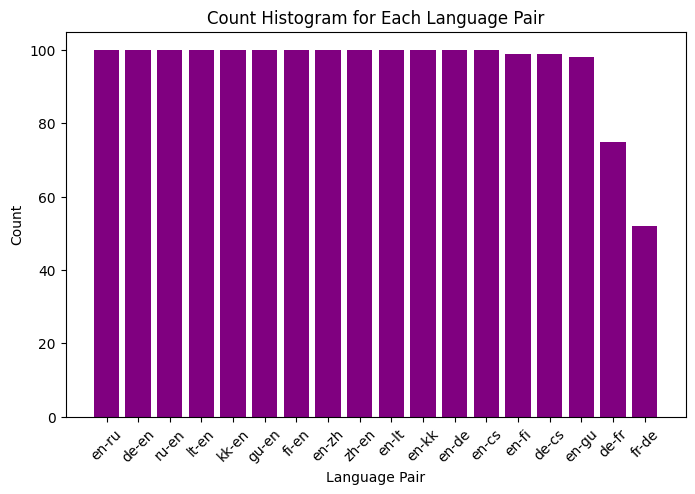

In [6]:
import matplotlib.pyplot as plt

count_df = wmt_da_df.groupby(["lp"]).size().reset_index(name="count")
sorted_count_df = count_df.sort_values(by="count", ascending=False)
plt.figure(figsize=(8, 5))
plt.bar(
    sorted_count_df["lp"],
    sorted_count_df["count"],
    color="purple",
)
plt.xlabel("Language Pair")
plt.ylabel("Count")
plt.title("Count Histogram for Each Language Pair")
plt.xticks(rotation=45)
plt.show()

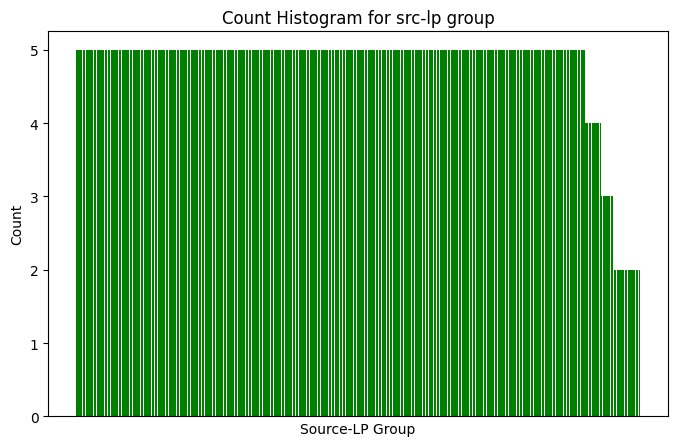

In [7]:
count_df = wmt_da_df.groupby(["src", "lp"]).size().reset_index(name="count")
sorted_count_df = count_df.sort_values(by="count", ascending=False)
plt.figure(figsize=(8, 5))
plt.bar(
    np.arange(len(sorted_count_df)),
    sorted_count_df["count"],
    color="green",
)
plt.xlabel("Source-LP Group")
plt.ylabel("Count")
plt.title("Count Histogram for src-lp group")
plt.xticks([], rotation=45)
plt.show()

As you can see we have roughly 100 entries per language and around 5 hypothesis for each source/lp pair, making it overall uniform across the different categories.

For MT metrics, we will focus on [BLEU](https://aclanthology.org/P02-1040/), [BERTScore](https://arxiv.org/abs/1904.09675) and [COMET](https://aclanthology.org/2020.emnlp-main.213/) (not to be confused with many other methods and tools called by the same name 😉 such as [[1]](https://arxiv.org/abs/1906.05317) and [[2]](https://www.comet.com/site/)):

- **BLEU (BiLingual Evaluation Understudy)**:
    You have already seen **BLEU (BiLingual Evaluation Understudy)** in Part 1 of this exercise session. BLEU score measures the similarity between the gold reference and the generated candidate. 100 means they are a perfect match, and 0 means some of the n-gram precisions do not get fulfilled. Note that this range may change to 1.0 to 0.0 depending on the implementation. such as the huggingface `evaluate` one:

    - **bleu:** As you learned in the exercise, the BLEU score is calculated by comparing the $n$-grams and combining their average precisions from $n$=1 to $n$=4 with a brevity penalty.
    - **bleu-1:** Geometric mean of 1-gram precisions; it does not use the brevity penalty.
    - **bleu-4:** Geometric mean of 4-gram precisions; it does not use the brevity penalty.
    - **bleu-brevity-penalty:** The brevity penalty penalizes generated sentences that are *too short* compared to the closest reference length with exponential decay.
- For **BERTScore** and **COMET**, answer the following questions to better understand how they calculate the metrics.

#### 🎯 TODO: Answer the following questions regarding BERTScore and COMET

**Q1: How is BERTScore calculated? Read the first three paragraphs in Section 3 -- called "Token representation", "Similarity Measure", and "BERTScore" -- in [this paper](https://arxiv.org/pdf/1904.09675.pdf) and give a technical description of how the BERTScore precision/recall/f1 is calculated. You do not need to describe anything outside the scope of these specific paragraphs.**

*Your answer here*

BERTScore computes a similarity score for tokens in the candidate and tokens in the reference, where tokens are tokenized using a BERT-family model. However, instead of exact matches like BLEU, they compute a soft token cosine similarity value using the respective BERT-family model's contextual embeddings. The soft-matching only counts the similarity of the most similar token in the reference or candidate, depending on whether it's a precision or recall measurement.
- **bertscore-precision:**  Matches each token in the tokenized reference $\tilde{x}$ to a token in the tokenized candidate $x$ to compute precision. Then divides by the length of the reference.
- **bertscore-recall:** Matches each token in the tokenized candidate $x$ to a token in the tokenized reference $\tilde{x}$ to compute recall. Then divides by the length of the candidate.
- **bertscore-f1:** Calculates an F-1 score given the two prior measurements.

**Q2: How is COMET trained and calculated? Read Section 2.4 -- "Translation Ranking Model" -- in [this paper](https://arxiv.org/pdf/2009.09025.pdf) and give a technical description.**

*Your answer here*

The translation ranking model is trained with "better" and "worse" hypothesis examples. Once the representation for both of these are extracted through pooling such as a CLS token, as well as for the source inputs, then a triplet margin loss is used to train the model in learning the ranking. In particular the model learns to associate the "better" hypothesis closer to the "source"' representation.



### 2.2 NLG metric calculation

Now that you are exposed to parts of the dataset and the metrics, it's time to calculate scores over the generated hypotheses. Head over to the file `mt_eval.py` and observe the `calculate_metrics` function. In particular, you will be calculating [BLEU](https://huggingface.co/spaces/evaluate-metric/bleu), [BERTScore](https://huggingface.co/spaces/evaluate-metric/bertscore), and [COMET](https://huggingface.co/spaces/evaluate-metric/comet) with the linked huggingface evaluate functions. 

While a GPU may help speed up the calculation in this part, it is not necessary (it will take ~10-20 min on CPU). Now run the following cell to generate the `part2_metrics.json` file.

In [8]:
from mt_eval import calculate_metrics

calculate_metrics()

1723


Fetching 5 files: 100%|██████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.19s/it]
Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`
Encoder model frozen.
/datadrive/madhur/anaconda3/envs/mnlp_exercises/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


--------------------------------------------------
Calculating BLEU...
metric name instance:  bleu
id,score pair instance:  ('9841', 0.0)
Done.
--------------------------------------------------
Calculating BERTScore...


  0%|                                                                                   | 0/18 [00:00<?, ?it/s]

calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.64it/s]


computing greedy matching.



  6%|████▏                                                                      | 1/18 [00:06<01:47,  6.30s/it]

done in 2559565.26 seconds, 0.00 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.20it/s]


computing greedy matching.



 11%|████████▎                                                                  | 2/18 [00:24<03:31, 13.25s/it]

done in 2559582.38 seconds, 0.00 sentences/sec
calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.36it/s]


computing greedy matching.



 17%|████████████▌                                                              | 3/18 [00:24<01:52,  7.47s/it]

done in 2559607.97 seconds, 0.00 sentences/sec
calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.72it/s]


computing greedy matching.



 22%|████████████████▋                                                          | 4/18 [00:25<01:04,  4.58s/it]

done in 2559583.12 seconds, 0.00 sentences/sec
calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.53it/s]


computing greedy matching.



 28%|████████████████████▊                                                      | 5/18 [00:25<00:38,  2.98s/it]

done in 2559583.27 seconds, 0.00 sentences/sec
calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.72it/s]


computing greedy matching.



 33%|█████████████████████████                                                  | 6/18 [00:25<00:24,  2.02s/it]

done in 2559584.43 seconds, 0.00 sentences/sec
calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.35it/s]


computing greedy matching.



100%|███████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 140.07it/s]


done in 2559585.62 seconds, 0.00 sentences/sec


 39%|█████████████████████████████▏                                             | 7/18 [00:25<00:15,  1.42s/it]

calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.27it/s]


computing greedy matching.



 44%|█████████████████████████████████▎                                         | 8/18 [00:25<00:10,  1.02s/it]

done in 2559583.79 seconds, 0.00 sentences/sec
calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.10it/s]


computing greedy matching.



 50%|█████████████████████████████████████▌                                     | 9/18 [00:25<00:06,  1.33it/s]

done in 2559583.94 seconds, 0.00 sentences/sec
calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.15it/s]


computing greedy matching.



 56%|█████████████████████████████████████████                                 | 10/18 [00:26<00:04,  1.74it/s]

done in 2559584.12 seconds, 0.00 sentences/sec
calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.52it/s]


computing greedy matching.



 61%|█████████████████████████████████████████████▏                            | 11/18 [00:31<00:13,  1.93s/it]

done in 2559589.12 seconds, 0.00 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.48it/s]


computing greedy matching.



 67%|█████████████████████████████████████████████████▎                        | 12/18 [00:31<00:09,  1.56s/it]

done in 2559589.82 seconds, 0.00 sentences/sec
calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.16it/s]


computing greedy matching.



 72%|█████████████████████████████████████████████████████▍                    | 13/18 [00:32<00:06,  1.25s/it]

done in 2559638.38 seconds, 0.00 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.66it/s]


computing greedy matching.



 78%|█████████████████████████████████████████████████████████▌                | 14/18 [00:33<00:04,  1.12s/it]

done in 2559591.20 seconds, 0.00 sentences/sec
calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.74it/s]


computing greedy matching.



 83%|█████████████████████████████████████████████████████████████▋            | 15/18 [00:34<00:03,  1.08s/it]

done in 2559592.17 seconds, 0.00 sentences/sec
calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.56it/s]


computing greedy matching.



 89%|█████████████████████████████████████████████████████████████████▊        | 16/18 [00:35<00:02,  1.12s/it]

done in 2559593.40 seconds, 0.00 sentences/sec
calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.09it/s]


computing greedy matching.



 94%|█████████████████████████████████████████████████████████████████████▉    | 17/18 [00:36<00:01,  1.11s/it]

done in 2559594.48 seconds, 0.00 sentences/sec
calculating scores...
computing bert embedding.



100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.21it/s]


computing greedy matching.



100%|██████████████████████████████████████████████████████████████████████████| 18/18 [00:37<00:00,  2.10s/it]
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


done in 2559595.69 seconds, 0.00 sentences/sec
metric name instance:  bertscore-precision
id,score pair instance:  ('9841', 0.8183464407920837)
Done.
--------------------------------------------------
Calculating COMET...


Predicting DataLoader 0: 100%|███████████████████████████████████████████████| 108/108 [00:11<00:00,  9.78it/s]


metric name instance:  comet
id,score pair instance:  ('9841', 0.4748193621635437)
Done.


{'bleu': {'9841': 0.0,
  '9842': 0.0,
  '9843': 0.0,
  '9844': 0.0,
  '9845': 0.0,
  '9846': 0.0,
  '9847': 0.0,
  '9848': 0.0,
  '9849': 0.0,
  '9850': 0.0,
  '9941': 0.6147881529512643,
  '9942': 0.3850322886878713,
  '9943': 0.0,
  '9944': 0.6262844962765468,
  '9945': 0.45077634573237174,
  '9946': 0.17070057360194496,
  '9947': 0.2630438273136112,
  '9948': 0.12429356665051385,
  '9949': 0.2590871538943314,
  '9950': 0.2181359087876921,
  '10056': 0.0,
  '10057': 0.32559641262003014,
  '10058': 0.20149416157064579,
  '10059': 0.2490328638846773,
  '10060': 0.0,
  '10136': 0.10458892692943761,
  '10137': 0.29882396932767114,
  '10138': 0.586858809641322,
  '10139': 0.35249008608213545,
  '10140': 0.2660656499435371,
  '10171': 0.2094841271665114,
  '10172': 0.33157961519920826,
  '10173': 0.2519460242629816,
  '10174': 0.0,
  '10175': 0.0,
  '10201': 0.28895171772257205,
  '10202': 0.3571363417889781,
  '10203': 0.1146994166570641,
  '10204': 0.2056425935018132,
  '10205': 0.150368

### 2.3 Correlation calculation

- We have succesfully calculated the NLG metrics for each hypothesis and stored them in `part2_metrics.json`. 
- Now, we will calculate how much these scores correlate with human judgements using the `evaluate_metrics` function in `mt_eval.py`. 
- We will calculate [Kendall's tau](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) which requires ordinal, or in other words, ranked associations between data. One way we can turn the DA scores into ranks is to consider the human scores for various hypothesis of the same **source** and **language pair** as defining such ranks. For that we will create (worst_hypothesis, better_hypothesis) pair combinations. After getting the data we will calculate the correlation between the human scores and the metric scores and save it in `part2_corr.json`.

- Note that there are several ways to calculate Kendall's tau, and we implement the first definition given in [this Wikipedia article](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient).

You will not need a GPU for this part. Now run the following cell to generate the `part2_corr.json` file.

In [10]:
from mt_eval import evaluate_metrics

evaluate_metrics()

   entry_id     lp                                   src  \
0      9841  de-cs  18 Löcher, um ein Zeichen zu setzen.   
1      9842  de-cs  18 Löcher, um ein Zeichen zu setzen.   
2      9843  de-cs  18 Löcher, um ein Zeichen zu setzen.   
3      9844  de-cs  18 Löcher, um ein Zeichen zu setzen.   
4      9845  de-cs  18 Löcher, um ein Zeichen zu setzen.   

                                  mt                        ref     score  \
0                18 jamek na ceduli.  18 jamek na to se ukázat. -0.922435   
1       18 děr, aby se dalo bojovat.  18 jamek na to se ukázat. -1.615103   
2             18 jamek pro označení.  18 jamek na to se ukázat. -1.736768   
3  18 díry, aby se dalo dát znamení.  18 jamek na to se ukázat. -1.008528   
4               18 jamek na znamení.  18 jamek na to se ukázat.  0.461584   

    raw  annotators domain  year  
0  51.0           1   news  2019  
1   2.0           1   news  2019  
2   9.0           1   news  2019  
3  49.0           1   news  2019  
4

Awesome! ✨ All you have left to do now is to analyze the results.

### 2.4 Correlation analysis

Here is a sorted version of the results you got:

In [12]:
from mt_eval import load_json

corr_dict = load_json("part2_corr.json")
dict(sorted(corr_dict.items(), key=lambda item: item[1]))

{'bleu-4': 0.13309459862727543,
 'bleu': 0.14891077290361085,
 'bleu-1': 0.1539838854073411,
 'bertscore-recall': 0.22829006266786034,
 'bertscore-f1': 0.23246792002387348,
 'bertscore-precision': 0.23515368546702478,
 'comet': 0.29036108624291257}

#### 🎯 TODO: Answer the following questions:

**Q3: Given your understanding of BLEU, BERTScore and COMET, how would you interpret the Kendall's Tau correlation results? Which ones are the least and most correlated? What is your hypothesis regarding the reasons behind the lowest correlation for one metric and the highest correlation in the other?**

*Your answer here*

BLEU has the lowest correlation as it relies on surface-level n-gram overlap and ignores semantics. BERTScore performs better by using contextual embeddings but isn’t trained on human judgments. COMET combines both contextual understanding and supervision from human annotations, leading to the highest correlation.

**Q4: Assume you have a large set of story beginnings and you would like to evaluate how well a model completes the stories. What problem would you run into with BLEU and COMET? Would the same disadvantages apply to BERTScore and why? Give your justification.**

*Your answer here*

BLEU and COMET would fail because they are too anchored in being similar to the reference. BERTScore would probably be more "optimistic" and give a higher score to a reasonable generation as it is untrained and computes a soft token cosine similarity rather than an exact one.
